# 🐋 Whale Migration Detection — Jupyter Notebook

Этот ноутбук демонстрирует работу модели, которая обнаруживает китов
на изображениях и помогает исследовать их миграцию.

Модель развёрнута в **Roboflow (workflow)** и вызывается через Python.
Ноутбук подходит для запуска локально в Jupyter или в Google Colab.


## 1. Установка зависимостей

> В Colab этот блок можно раскомментировать и выполнить.
> Локально зависимости лучше ставить через `pip install -r requirements.txt`.


In [1]:
# В Colab раскомментируйте:
# !pip install inference-sdk pillow matplotlib


In [3]:
!pip install inference-sdk --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.12.0.88
    Uninstalling opencv-python-4.12.0.88:
      Successfully uninstalled opencv-python-4.12.0.88
  Attempting uninstall: aiohttp
    Found existing installation: aiohttp 3.13.2
    Uninstalling aiohttp-3.13.2:
      Successfully uninstalled aiohttp-3.13.2


In [4]:
from inference_sdk import InferenceHTTPClient


## 2. Импорт библиотек и настройка Roboflow

In [13]:
from pathlib import Path
import json
from typing import Dict, Any, List

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

from inference_sdk import InferenceHTTPClient

# === Настройки Roboflow ===

API_URL = "https://serverless.roboflow.com"

# Вставьте сюда СВОЙ API-ключ Roboflow.
# (В Colab не коммитьте его в репозиторий, лучше хранить в переменной окружения.)
API_KEY = ""

WORKSPACE_NAME = "natalia-brodo-s-workspace"
WORKFLOW_ID = "find-gray-whales-and-humpback-whales"

client = InferenceHTTPClient(api_url=API_URL, api_key=API_KEY)
print("Клиент Roboflow готов.")


Клиент Roboflow готов.


In [12]:
API_URL = "https://serverless.roboflow.com"
API_KEY = "LF97mxymSNiH0SEHPQXk"
WORKSPACE_NAME = "natalia-brodo-s-workspace"
WORKFLOW_ID = "find-gray-whales-and-humpback-whales"

client = InferenceHTTPClient(
    api_url=API_URL,
    api_key=API_KEY
)


In [14]:
API_URL = "https://serverless.roboflow.com"
API_KEY = "LF97mxymSNiH0SEHPQXk"
WORKSPACE_NAME = "natalia-brodo-s-workspace"
WORKFLOW_ID = "find-gray-whales-and-humpback-whales"

client = InferenceHTTPClient(
    api_url=API_URL,
    api_key=API_KEY
)


## 3. Функции вызова workflow и разбора результата

In [15]:
def run_workflow_on_image(image_path: str) -> Dict[str, Any]:
    """Отправляем изображение в workflow и получаем результат.

    Параметр image_path: путь к локальному файлу.
    Возвращает словарь (JSON-ответ от Roboflow).
    """
    result = client.run_workflow(
        workspace_name=WORKSPACE_NAME,
        workflow_id=WORKFLOW_ID,
        images={"image": image_path},
        use_cache=True,
    )
    return result


def collect_predictions(node: Any, acc: List[Dict[str, Any]]):
    """Рекурсивно ищем в ответе все объекты, похожие на предсказания.

    Критерий: в словаре есть ключи 'class' и 'confidence'.
    """
    if isinstance(node, dict):
        if "class" in node and "confidence" in node:
            acc.append(node)
        for v in node.values():
            collect_predictions(v, acc)
    elif isinstance(node, list):
        for item in node:
            collect_predictions(item, acc)


def get_best_prediction(result: Dict[str, Any]) -> Dict[str, Any] | None:
    """Выбираем предсказание с максимальной уверенностью."""
    preds: List[Dict[str, Any]] = []
    collect_predictions(result, preds)
    if not preds:
        return None
    return max(preds, key=lambda p: p.get("confidence", 0.0) or 0.0)


## 4. Визуализация: рамка + подпись класса

Ниже функция рисует красную рамку и крупную подпись вида кита
(`gray whale` или `humpback whale`) прямо внутри рамки. Результат
также сохраняется в папку `results/`.


In [16]:
def draw_box_with_label(img: Image.Image, pred: Dict[str, Any]) -> Image.Image:
    """Рисуем рамку и подпись класса.

    Ожидается формат предсказания Roboflow:
      x, y, width, height (в пикселях), class, confidence.
    """
    img = img.convert("RGB")
    draw = ImageDraw.Draw(img)

    cls = pred.get("class", "whale")
    conf = pred.get("confidence", 0.0)

    x = pred.get("x")
    y = pred.get("y")
    w = pred.get("width")
    h = pred.get("height")
    if None in (x, y, w, h):
        return img

    x1 = int(x - w / 2)
    y1 = int(y - h / 2)
    x2 = int(x + w / 2)
    y2 = int(y + h / 2)

    # Рамка
    draw.rectangle([x1, y1, x2, y2], outline="red", width=6)

    # Подпись
    label = f"{cls} ({conf:.2f})"

    try:
        font_size = max(28, img.width // 18)
        font = ImageFont.truetype("arial.ttf", font_size)
    except OSError:
        font = ImageFont.load_default()

    try:
        bbox = font.getbbox(label)
        text_w = bbox[2] - bbox[0]
        text_h = bbox[3] - bbox[1]
    except Exception:
        text_w, text_h = draw.textsize(label, font=font)

    pad_x, pad_y = 8, 4
    bg_w, bg_h = text_w + 2 * pad_x, text_h + 2 * pad_y

    bg_x1 = max(x1, 0)
    bg_y1 = max(y1, 0)
    bg_x2 = bg_x1 + bg_w
    bg_y2 = bg_y1 + bg_h

    # Полупрозрачная чёрная плашка
    img_rgba = img.convert("RGBA")
    bg = Image.new("RGBA", (bg_w, bg_h), (0, 0, 0, 190))
    img_rgba.paste(bg, (bg_x1, bg_y1), bg)

    draw = ImageDraw.Draw(img_rgba)
    draw.text((bg_x1 + pad_x, bg_y1 + pad_y), label, fill="white", font=font)

    return img_rgba.convert("RGB")


def show_and_save(image_path: str, result: Dict[str, Any], results_dir: Path = Path("results")):
    results_dir.mkdir(exist_ok=True)

    img = Image.open(image_path)
    best = get_best_prediction(result)

    if best is None:
        print("Модель не нашла кита на изображении.")
        plt.imshow(img)
        plt.axis("off")
        plt.show()
        return

    out_img = draw_box_with_label(img, best)

    plt.figure(figsize=(7, 5))
    plt.imshow(out_img)
    plt.axis("off")
    plt.show()

    out_path = results_dir / f"{Path(image_path).stem}_vis.png"
    out_img.save(out_path)
    print("✅ Результат сохранён в:", out_path)


## 5. Запуск на одном изображении

Укажите путь к файлу изображения (локальному). В Colab можно
предварительно загрузить файл через интерфейс слева.


Ключи верхнего уровня ответа: ['predictions', 'visualization']


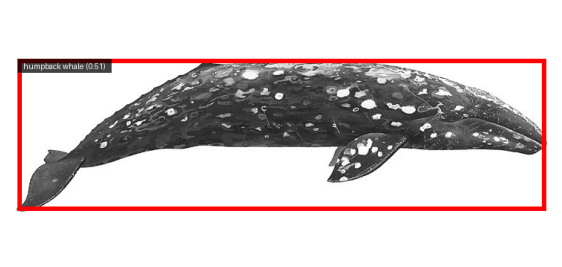

✅ Результат сохранён в: results/ck_vis.png


In [19]:
IMAGE_PATH = "/content/ck.jpg"  # замените на свой путь

result = run_workflow_on_image(IMAGE_PATH)
print("Ключи верхнего уровня ответа:", list(result[0].keys()))
show_and_save(IMAGE_PATH, result)

## 6. Обработка нескольких изображений из папки

Можно положить несколько фотографий китов в папку `examples/`
и обработать их одной ячейкой.


In [20]:
IMAGES_DIR = Path("examples")

all_results = {}
for img_path in sorted(IMAGES_DIR.glob("*.jpg")):
    print("\n=== Обрабатываем:", img_path.name, "===")
    result = run_workflow_on_image(str(img_path))
    all_results[str(img_path)] = result
    show_and_save(str(img_path), result)


## 7. Выводы

Используя такой ноутбук, можно:

- тестировать работу модели на собственных фотографиях китов;
- настраивать пороги и визуализацию;
- собирать данные для дальнейшего анализа миграции:
  - какие виды встречаются в конкретном регионе;
  - как часто удаётся зафиксировать появления;
  - как меняется активность по сезонам.

Эти данные помогают исследователям и экологам принимать
обоснованные решения для защиты популяций китов и их
естественной среды обитания.
